# OSD decoding

For the purposes of this notebook, the ideas presented here are from:

[Degenerate Quantum LDPC Codes With Good Finite Length Performance](https://arxiv.org/pdf/1904.02703).

[Tour de gross: A modular quantum computer based on bivariate bicycle codes](https://arxiv.org/pdf/2506.03094)

[Decoding Across the Quantum LDPC Code Landscape](https://arxiv.org/pdf/2005.07016)
 some code of which is [here](https://github.com/quantumgizmos/bp_osd).

[Improved belief propagation is sufficient for real-time decoding of quantum memory](https://arxiv.org/pdf/2506.01779) which introduces relay BP, with some code [here](https://github.com/FranciscoRevson/relay-BP-IBM).

[Fully Parallelized BP Decoding for Quantum LDPC Codes Can Outperform BP-OSD](https://arxiv.org/html/2507.00254v2)



Fix $n$ and a linear binary code, $\mathcal{C}$ of dimension $k$. So $\mathcal{C} \subset F^n_2$ such that $\mathcal{C} \cong F_2^k$ and in particular has $2^k$ elements. 
Choose a generator matrix $G$, meaning a matrix which row space spans the code, and a parity matrix $H$, namely a matrix which kernel is the code.
By definition of the parity matrix, if $c\in \mathcal{C}$ then $H \cdot c = \vec{0}$. Generally we call the resulting vector $H \cdot w = s$ the syndrome. 

Excersize:
Show that if $v,w$ have the same syndrome, then they differ by a codeword.

For a set of indices, $I \subset {1,..n} = [n]$, we say that $I$ is an information set for the code $\mathcal{C}$, if:

$$C_I:=\{c_{i\in I} : c\in \mathcal{C}\} = F_2^k$$

Meaning, that when we restrict each $n$ dimensional codeword $c$ to the set of indices in $I$, and go over all codewords in $\mathcal{C}$, we get the set $F_2^k$, and in fact we get an isomorphism of vector spaces between $\mathcal{C}$ and $F_2^k$ which is a projection.

Excersize:
1.  Show that for an information set $I$, the map: $P_I: \mathcal{C} \rightarrow F_2^k$ defined by: $P_I(c) = P_I(c_{i\in [n]}) = c_{i\in I}$ is linear, one to one and onto, i.e., it is an isomorphism of vector spaces.
2. Conclude that if $P_I(c) = P_I(c')$ then $c=c'$

Every pair of information set and syndrome for the code $\mathcal{C}$ and $H$ gives us an encoding $E(x) = E(s,I,x):F_2^k \rightarrow F^n_2$: first, the bijection $P_I$ picks one representative of $\mathcal{C}$ - the one that agrees with x over all indices in $I$. Then the rest of the values for indices outside $I$ are uniqely determined by the syndrome.


Now let's assume we have a word $c' = c + e$, and we want to recover $c$. We also have an estimate $\hat{e}$ of $e$, but we find that $H \cdot \hat{e} \neq H \cdot e$, so we have evidence that $\hat{e} \neq e$. 
If we knoew of an information set $I$ such that $e_I = \hat{e}_I$, i.e., they agree on the set $I$, then the encoding $E(s = H\cdot e,I,\hat{e})$ would find us the right $e$.

Suppose further that our estimate of $\hat{e}$ was cooked from probabilities $p_i$, where $p_i$ is the probability of the error $e$ being $1$ at index $i$, i.e.:
$$p_i = P(e_i = 1)$$
And we decide that we estimate $\hat{e}$ using: $e_i = 1$ if $p_i >= 1/2$ and 0 otherwise.

This is why we introduce the notion of a reliability $\rho$ of an index $i$:
$$\rho_i = P(\hat{e}_i = e_i)$$
Which using our estimation rule means 
$$\rho_i = max(p_i, 1-p_i)$$
(since if $p_i$ is the bigger one, we decided $\hat{e_i}$ = 1, and otherwise, i.e. $1-p_i$  is bigger, and we decided $\hat{e_i}=0$ but either way we are as certain as $max(p_i, 1-p_i)$). 



BIN:



So suppose we knew, that the error part of $x = c + e$ occures outside some information set $J$, then we could find out the error precisely usining $E(s,J,\vec{0})$ for $s=H \cdot (c+e) = H \cdot e$


In [1]:

import numpy as np
import matplotlib.pyplot as plt
from qecc.polynomialCodes import codes, A1_HX, A1_HZ, A2_HX, A2_HZ, A3_HX, A3_HZ, A4_HX, A4_HZ, A5_HX, A5_HZ,  A6_HX, A6_HZ
seed = 777
localRandom = np.random.RandomState(seed)
from qecc import funWithMatrices, logicals
import scipy
import copy

from qecc.osd import osdDecoder
H_X = A1_HX.astype(np.int32)
H_Z = A1_HZ.astype(np.int32)
L_X, L_Z = logicals.computeLogicals(H_X, H_Z)

# In the following we simulate errors, and set the reliability vector true to where errors occurred.
probabilityOfError = 0.1
# Create an error pattern
error = np.random.choice([0,1], size=(H_X.shape[1],), p=[1-probabilityOfError, probabilityOfError]).astype(np.int32)
print( f"Number of errors: {np.count_nonzero(error)}")
# Calculate the syndrome
syndrome = H_X @ error %2
coordinateReliabilities = error * probabilityOfError + (1-error)*(1-probabilityOfError) #np.ones(code.shape[1]) * probabilityOfError
solution, reliability = osdDecoder(H_X, syndrome, coordinateReliabilities)
print(f"{np.all(solution  == error)} ")



Number of errors: 26
True 


From [Stabilizer Codes and Quantum Error Correction](https://arxiv.org/pdf/quant-ph/9705052)
Now, there generally are many elements of G that commute with everything
 in S but are not actually in S. The set of elements in G that commute with all
 of S is defined as the centralizer C(S) of S in G. Because of the properties of S
 and G, the centralizer is actually equal to the normalizer N(S) of S in G, which
 is defined as the set of elements of G that fix S under conjugation. To see this,
 note that for any A ∈ G, M ∈ S,

In [ ]:

# Next we want to check if the decoder accidentally spitted out a logical operator, also known as decoder error, scilent data corription, false packet arrival etc.:
# We will use Qiskit to check for logical errors https://qiskit-community.github.io/qiskit-qec/tutorials/QEC_Framework_IEEE_2022.html
# We could also use  Logical operators of quantum codes (https://journals.aps.org/pra/pdf/10.1103/PhysRevA.79.062322) to write something from scratch


In [2]:


# If however we set the reliability vector to be uniform, we have decoding failure, even at low error rates.
probabilityOfError = 0.01
# Create an error pattern
error = np.random.choice([0,1], size=(code.shape[1],), p=[1-probabilityOfError, probabilityOfError]).astype(np.int32)
print( f"Number of errors: {np.count_nonzero(error)}")
# Calculate the syndrome
syndrome = code @ error %2
coordinateReliabilities = np.ones(code.shape[1]) * probabilityOfError
solution, reliability = osdDecoder(code, syndrome, coordinateReliabilities)
print(f"{np.all(solution  == error)} ")

NameError: name 'code' is not defined

In [ ]:
# So the conclusion is that we need reliabilities that are as accurate as possible
from qecc.memBP import decode
from qecc.funWithMatrices import binaryGaussianEliminationOnRows
from qecc.logicals import computeLogicals
matrix, matrixInverse, rank = binaryGaussianEliminationOnRows(copy.copy(H_X))
numberOfSamples = 20
OSD_DECODE = True

pError = np.linspace(0.001, 0.1, 10)
logicalErrors = np.zeros(len(pError))
ber = np.zeros(len(pError))
for p in range(len(pError)):
    probabilityOfError = pError[p]
    print(f"Simulating for probability of error {probabilityOfError}")
    for i in range(numberOfSamples):
        error = np.random.choice([0,1], size=(H_X.shape[1],), p=[1-probabilityOfError, probabilityOfError]).astype(np.int32)
        numberOfIterations = 50
        coordinateReliabilities = np.ones(H_X.shape[1]) * probabilityOfError
        initMarginals = np.ones(H_X.shape[1]) * np.log( (1 - probabilityOfError) / probabilityOfError )
        errorVector, marginals, converged, iteration = decode(H_X, initMarginals = initMarginals, errorProbabilities= initMarginals, sigma = (H_X @ error %2), Gammas = None, maxIterations=numberOfIterations, logProbabilities = True)
        #Count bit errors
        ber[p]+= np.sum(np.where(errorVector  == error, 0, 1))
        if OSD_DECODE:
            if not np.all(errorVector  == error):
                #print(f"Attempting OSD decoding:")
                solution, reliability = osdDecoder(H_X, (H_X @ error %2), marginals)
                #print(f"Is the solution exact ? {np.all(solution  == error)} ")
                #print(f"What about the syndrome of the solution: {np.all((H_X @ solution %2) == (H_X @ error %2))} ")
                #print(f"With reliability {reliability}")
                # Check whether a logical error occurred
                residualError = (error + solution) %2
                if np.any(H_X @ residualError % 2) or np.any(L_X @ residualError % 2):
                    #print("Logical error occurred!")
                    logicalErrors[p] += 1
    print(f"Logical error rate at probability of error {probabilityOfError} is {logicalErrors[p]/numberOfSamples}")



Simulating for probability of error 0.001
Logical error rate at probability of error 0.001 is 0.0
Simulating for probability of error 0.012
Logical error rate at probability of error 0.012 is 0.05
Simulating for probability of error 0.023000000000000003
Logical error rate at probability of error 0.023000000000000003 is 0.05
Simulating for probability of error 0.034
Logical error rate at probability of error 0.034 is 0.15
Simulating for probability of error 0.045000000000000005
Logical error rate at probability of error 0.045000000000000005 is 0.7
Simulating for probability of error 0.05600000000000001
Logical error rate at probability of error 0.05600000000000001 is 0.9
Simulating for probability of error 0.067
Logical error rate at probability of error 0.067 is 1.0
Simulating for probability of error 0.07800000000000001
Logical error rate at probability of error 0.07800000000000001 is 1.0
Simulating for probability of error 0.08900000000000001
Logical error rate at probability of erro

In [9]:
print(ber)

print(logicalErrors)


[   0.   51.   19.  122.  419.  547.  675.  716. 1241.  795.]
[ 0.  1.  1.  3. 14. 18. 20. 20. 20. 20.]


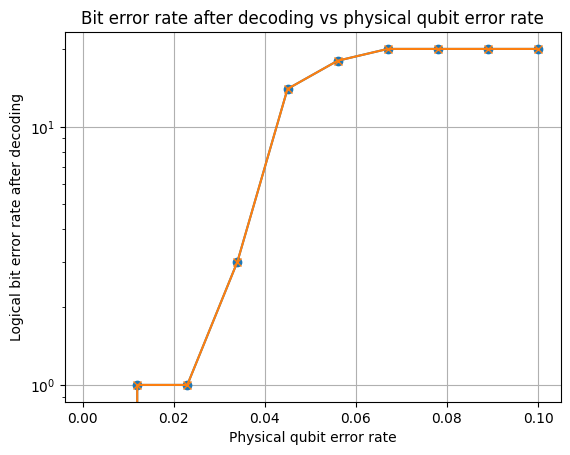

In [12]:

#plt.plot(pError, ber, marker='o')
plt.plot(pError, logicalErrors, marker='o')


plt.plot(pError, logicalErrors, marker='x')
plt.xlabel("Physical qubit error rate")
plt.ylabel("Logical bit error rate after decoding")
plt.yscale("log")
plt.title("Bit error rate after decoding vs physical qubit error rate")
plt.grid(True)
plt.show()


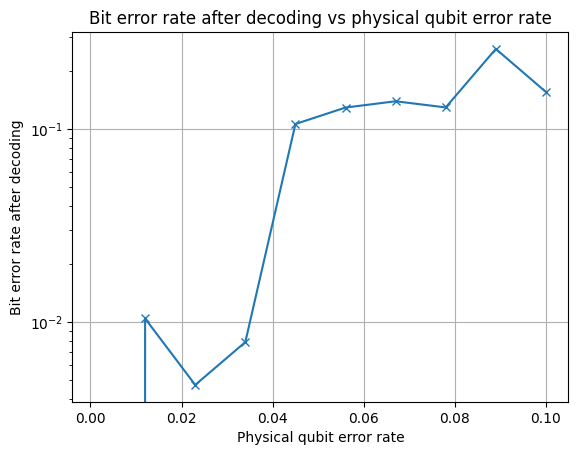

In [7]:

ber2 = ber / (numberOfSamples * H_X.shape[1])
plt.plot(pError, ber2, marker='x')
plt.xlabel("Physical qubit error rate")
plt.ylabel("Bit error rate after decoding")
plt.yscale("log")
plt.title("Bit error rate after decoding vs physical qubit error rate")
plt.grid(True)
plt.show()